# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("whitegrid")
import yfinance as yf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def d(*obj):
    for o in obj:
        display(o)

def p(*obj):
    for o in obj:
        print(o)

def _np(ls):
    return np.array(ls)

def r(f, unit=3):
    return round(f, unit)

/Users/kyro_m3pro/Desktop/Backtesting/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Get Data

In [2]:
def str_to_float(x:str):
    if type(x) == str:
        return float(x.replace(',' ,''))
    else:
        return x
    
vixf = pd.read_csv('Data/VIXF.csv').set_index('Date')[::-1]
vixf.index = pd.to_datetime(pd.to_datetime(vixf.index).strftime('%Y-%m-%d'))

cols_to_convert = ["Open", "High", "Low", "Price"]
for col in cols_to_convert:
    vixf[col] = vixf[col].apply(str_to_float)

In [3]:
spx = pd.read_csv('Data/SPX.csv', index_col='Date')
spx.index = pd.to_datetime(spx.index)

vix = pd.read_csv('Data/VIX.csv', index_col='Date')
vix.index = pd.to_datetime(vix.index)

In [4]:
df = pd.concat([spx['Adj Close'].rename('SPX'),
                vix['Adj Close'].rename('VIX'),
                vixf['Price'].rename('VIXF')], axis=1)
df = df.dropna()
spread = df['VIXF'] - df['VIX']

# Split

In [5]:
df_train = df.iloc[:int(len(df)*0.7)].copy()
df_test = df.loc[df_train.index[-1]:].copy()

# Transform

In [6]:
def smoothed_rolling_z(raw, window_sma: int, window_z: int):
    smoothed = raw.rolling(window_sma).mean()
    rolling_z = (smoothed - smoothed.rolling(window_z).mean()) / smoothed.rolling(window_z).std()
    return rolling_z

# Optimization (Training)

In [7]:
import sys
sys.path.append('../../qwok/')
from visualization import Visualization as Vis
from signal_oscillator import Price_Oscillator_Signal

In [8]:
minima_res_arr = []

for window_sma in range(1, 50, 5):
    print(window_sma, end=" ")
    for window_z in range(20, 50, 5):
        rolling_z = smoothed_rolling_z(spread, window_sma, window_z)
        for holding_n in range(5, 31):
            for order in range(1, 11):
                obj_singals = Price_Oscillator_Signal(df_train['SPX'], rolling_z)
                signals_minima = obj_singals.getSignals_OscillatorExtrema(order)
                
                obj_bt = Vis(close=df_train['SPX'], position=signals_minima, holding_n=holding_n, ta=rolling_z, asset_name='SPX')
                res_dict = {
                        'obj_bt': obj_bt,
                        'window_sma': window_sma,
                        'window_z': window_z,
                        'order': order,
                        'holding_n': holding_n,
                }
                for metrics, value in obj_bt.stat.items():
                    res_dict[metrics] = value
                minima_res_arr.append(res_dict)

1 6 11 16 21 26 31 36 41 46 

In [9]:
minima_bt = pd.DataFrame(minima_res_arr)

In [10]:
# if 1==0:
#     minima_bt.to_excel('Result (Minima) 5.0.xlsx')

## Heatmap

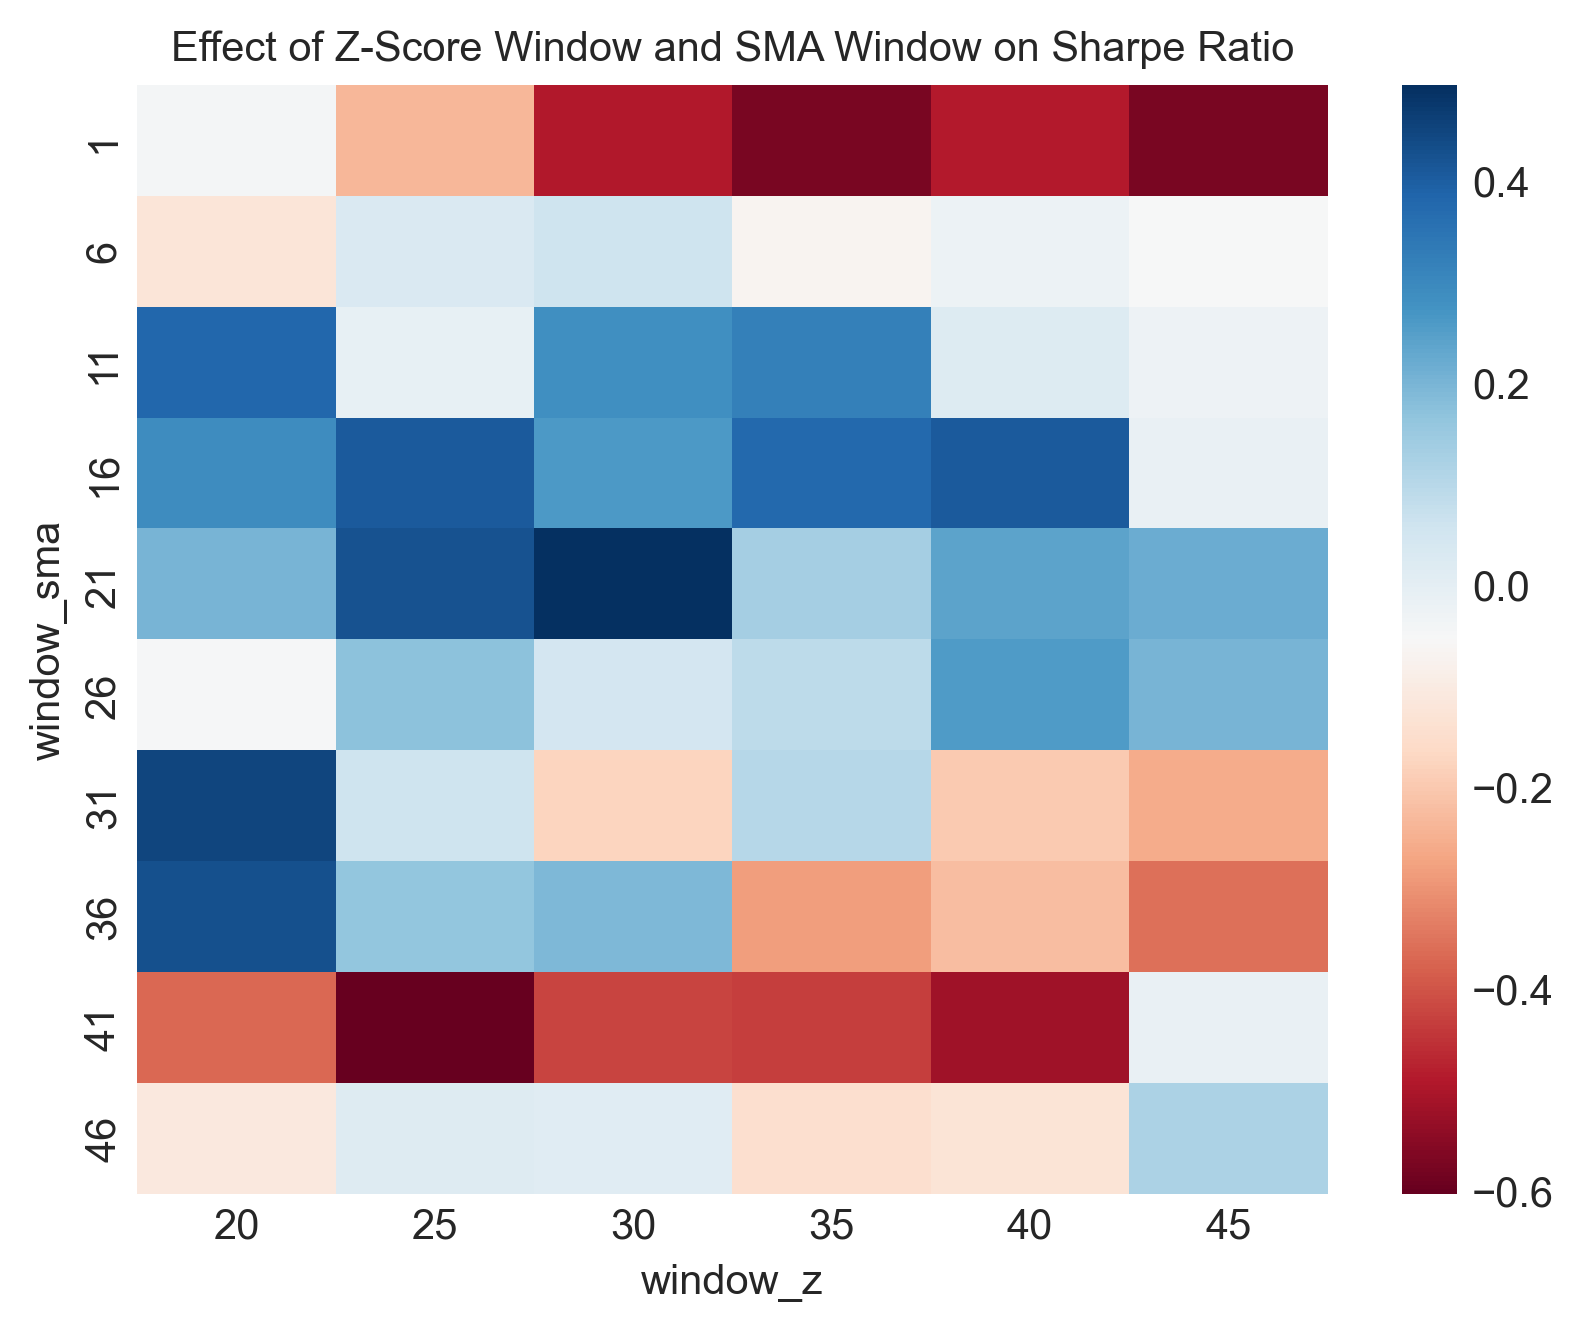

In [11]:
plt.figure(dpi=300)
ax = sns.heatmap(minima_bt.pivot_table(index='window_sma' , columns='window_z', values='sharpe_ratio', aggfunc='mean'), cmap='RdBu')
plt.title("Effect of Z-Score Window and SMA Window on Sharpe Ratio", fontsize=10)
plt.show()

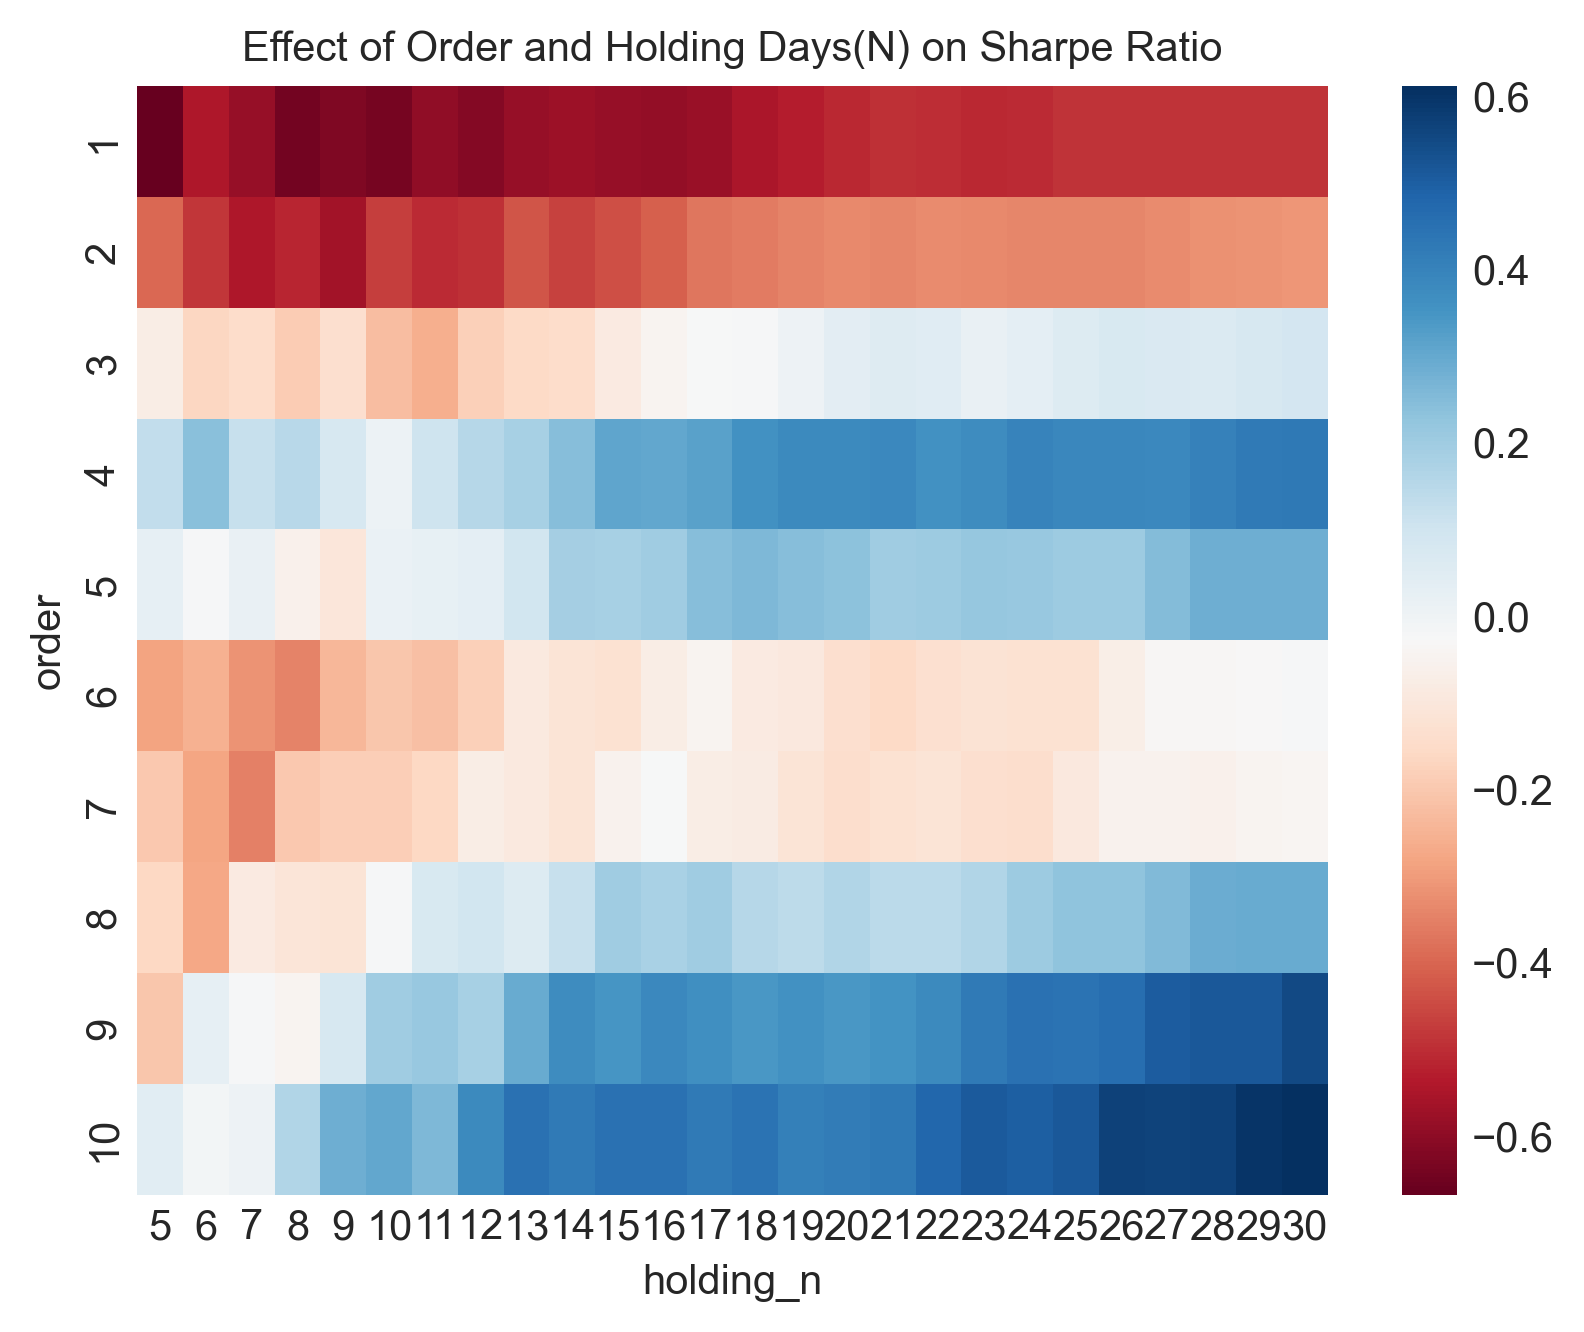

In [12]:
plt.figure(dpi=300)
ax = sns.heatmap(minima_bt.pivot_table(columns='holding_n', index='order', values='sharpe_ratio', aggfunc='mean'), cmap='RdBu')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.title("Effect of Order and Holding Days(N) on Sharpe Ratio", fontsize=10)
plt.show()

In [13]:
minima_bt.sort_values(by='calmar_ratio', ascending=False).head(5)

obj_bt  window_sma  window_z  \
5077  <visualization.Visualization object at 0x2acee...          16        25   
5087  <visualization.Visualization object at 0x2acff...          16        25   
5097  <visualization.Visualization object at 0x2ad8c...          16        25   
4019  <visualization.Visualization object at 0x2a40c...          11        35   
5057  <visualization.Visualization object at 0x2a52e...          16        25   

      order  holding_n      start        end  len_timeframe  leverage  \
5077      8         18 2022-01-03 2023-08-09            402         1   
5087      8         19 2022-01-03 2023-08-09            402         1   
5097      8         20 2022-01-03 2023-08-09            402         1   
4019     10         16 2022-01-03 2023-08-09            402         1   
5057      8         16 2022-01-03 2023-08-09            402         1   

      resolution(hr)  ...  expected_return_short  hit_rate  \
5077            24.0  ...                0.00115   0.53292   
5087            24.0  ...                0.00116   0.53086   
5097            24.0  ...                0.00132   0.53049   
4019            24.0  ...                0.00144   0.53725   
5057            24.0  ...                0.00100   0.52273   

      expected_return_hit  expected_return_miss  win_rate  sharpe_ratio  \
5077              0.01041              -0.00840   0.45213       1.88997   
5087              0.01036              -0.00840   0.45867       1.83910   
5097              0.01057              -0.00847   0.46524       1.90826   
4019              0.00999              -0.00796   0.36436       1.83348   
5057              0.01046              -0.00826   0.42593       1.75070   

      sortino_ratio  calmar_ratio  time_under_water  maximum_drawdown  
5077        2.97338       5.67128           0.72872           0.05272  
5087        2.93577       5.49649           0.72800           0.05315  
5097        3.08229       5.28714           0.74599           0.05819  
4019        2.50680       5.22148           0.69947           0.04806  
5057        2.74064       5.01076           0.73280           0.05440  

[5 rows x 30 columns]

# Validation

In [14]:
idx = 4913 #4913 #2073
print(minima_bt.iloc[idx])
this_obj = minima_bt.loc[idx, 'obj_bt']

obj_bt                       <visualization.Visualization object at 0x2ac11...
window_sma                                                                  16
window_z                                                                    20
order                                                                        4
holding_n                                                                   28
start                                                      2022-01-03 00:00:00
end                                                        2023-08-09 00:00:00
len_timeframe                                                              402
leverage                                                                     1
resolution(hr)                                                            24.0
count_day_tradable_yearly                                                  252
long_short_ratio                                                        1.4375
holding_ratio                                       

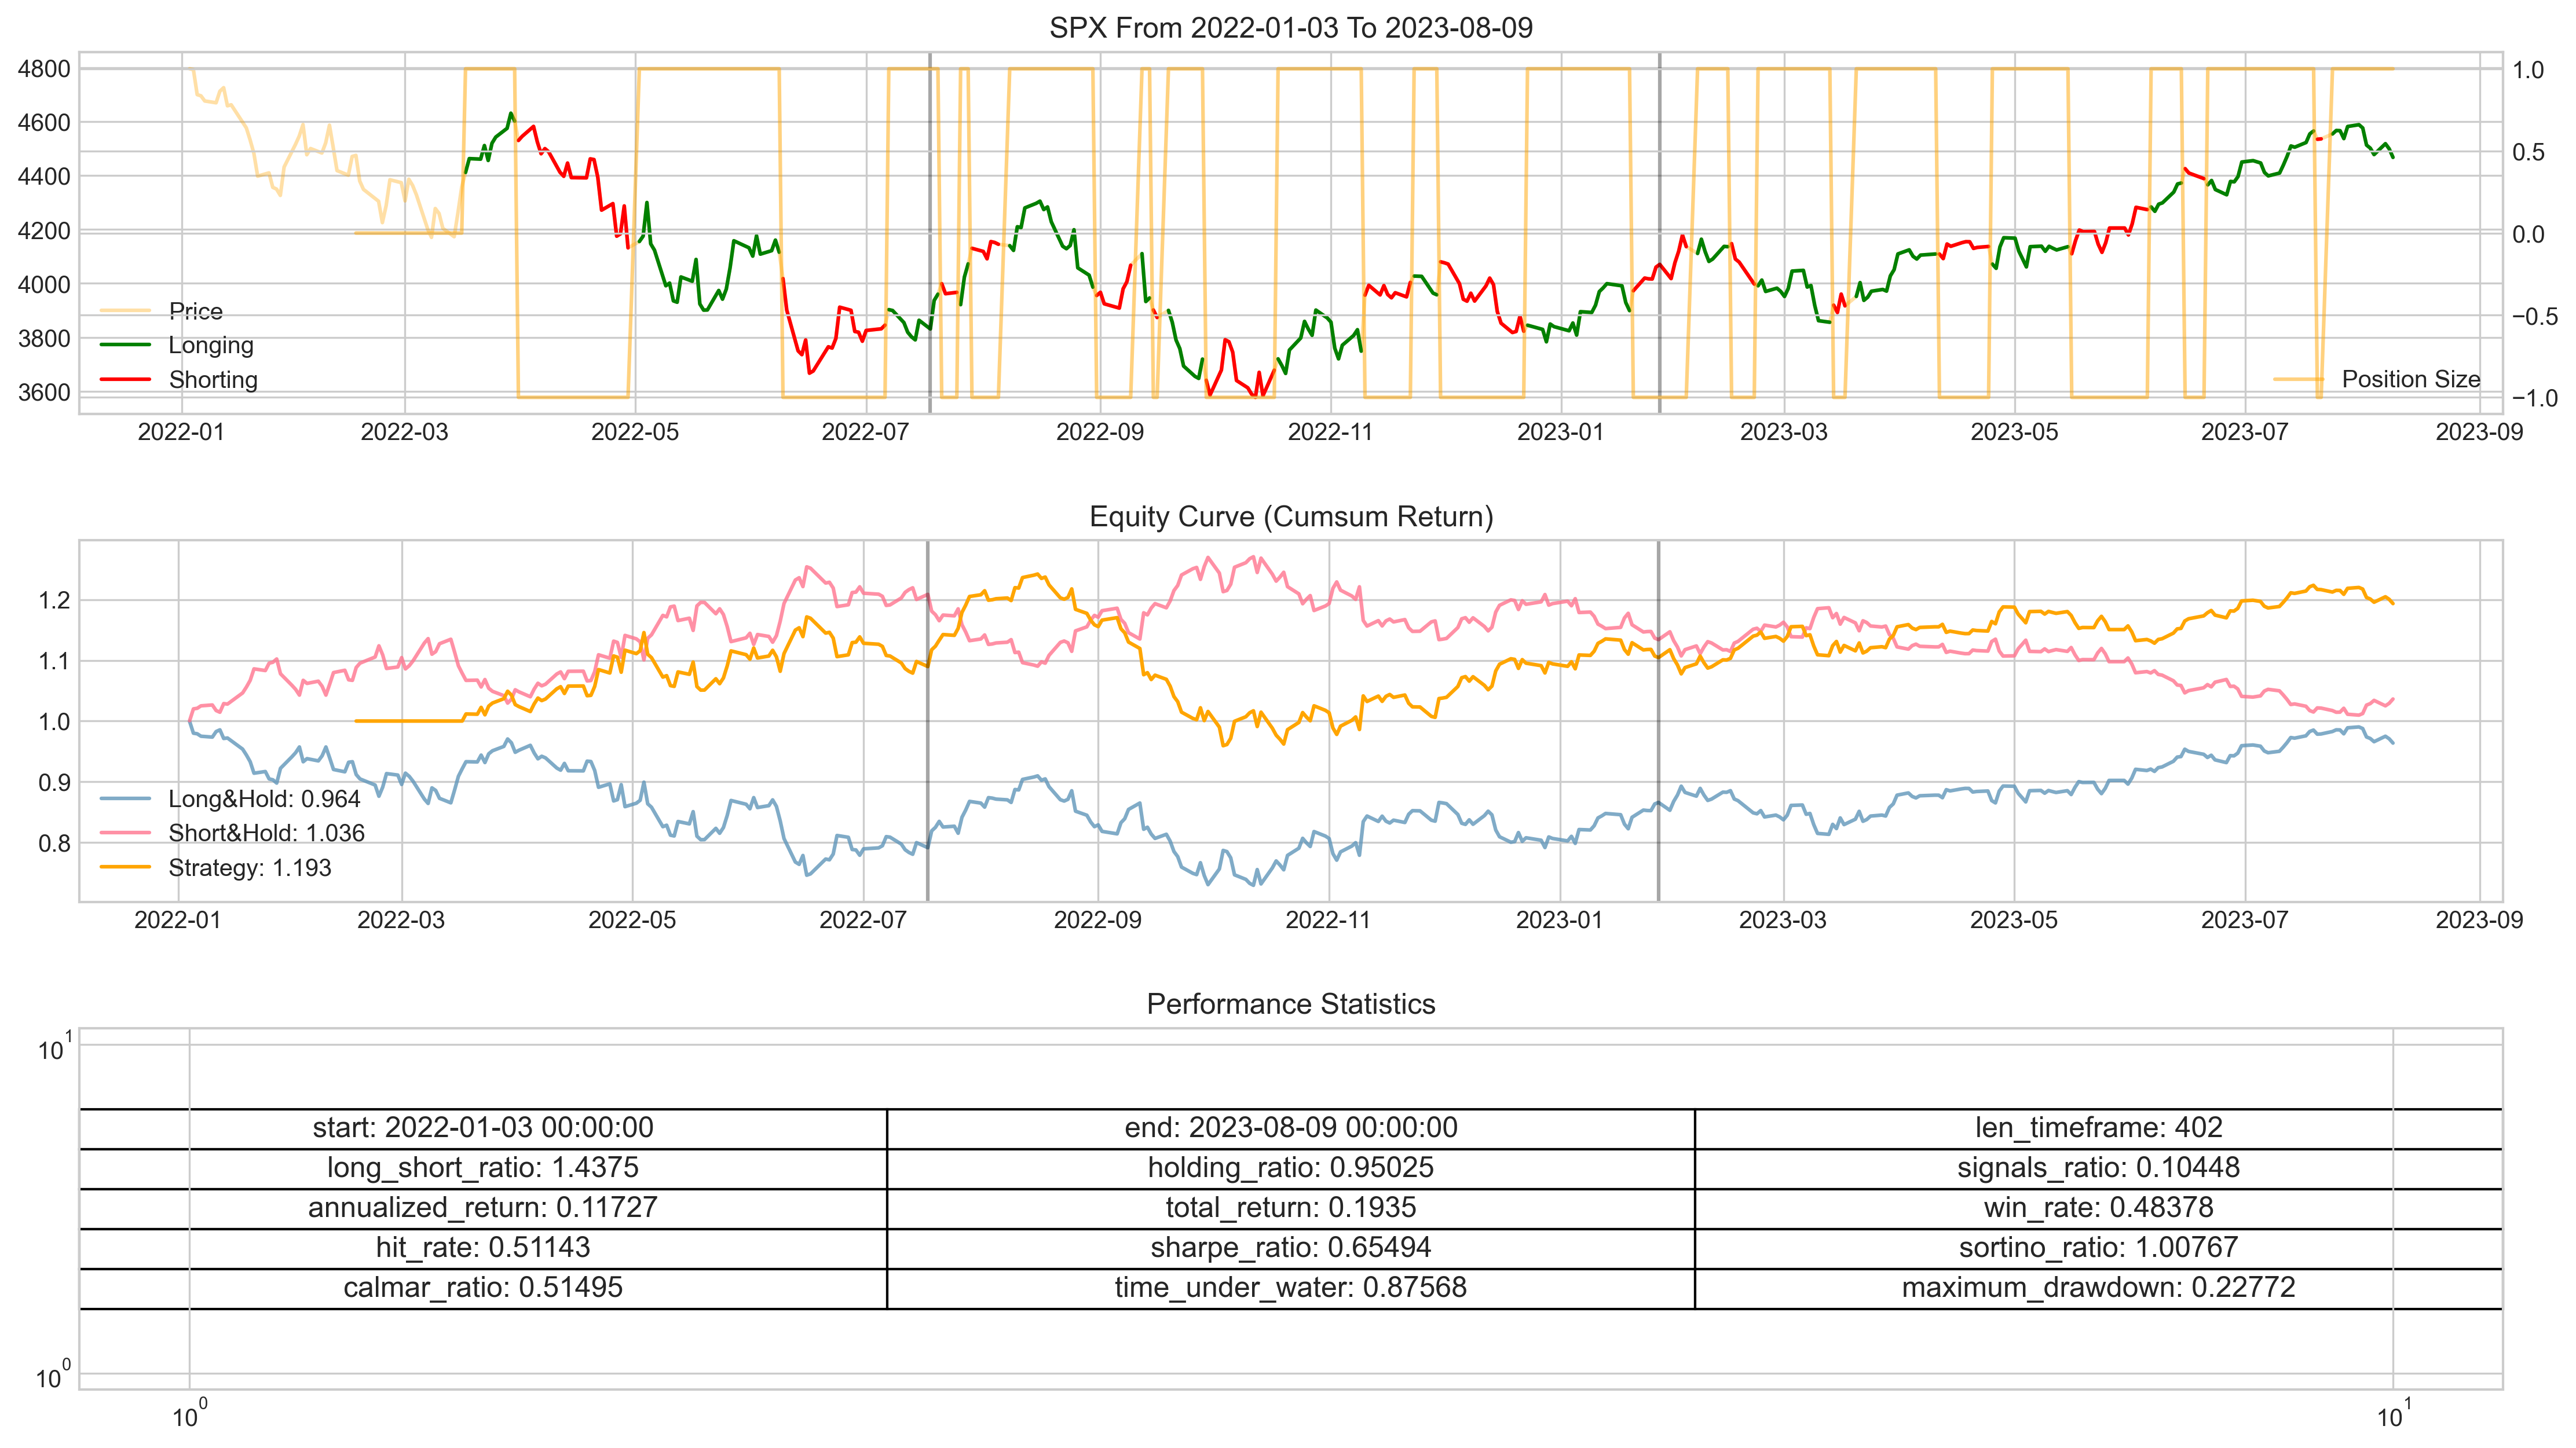

In [15]:
this_obj.plot_general(config_position={'plot':True})

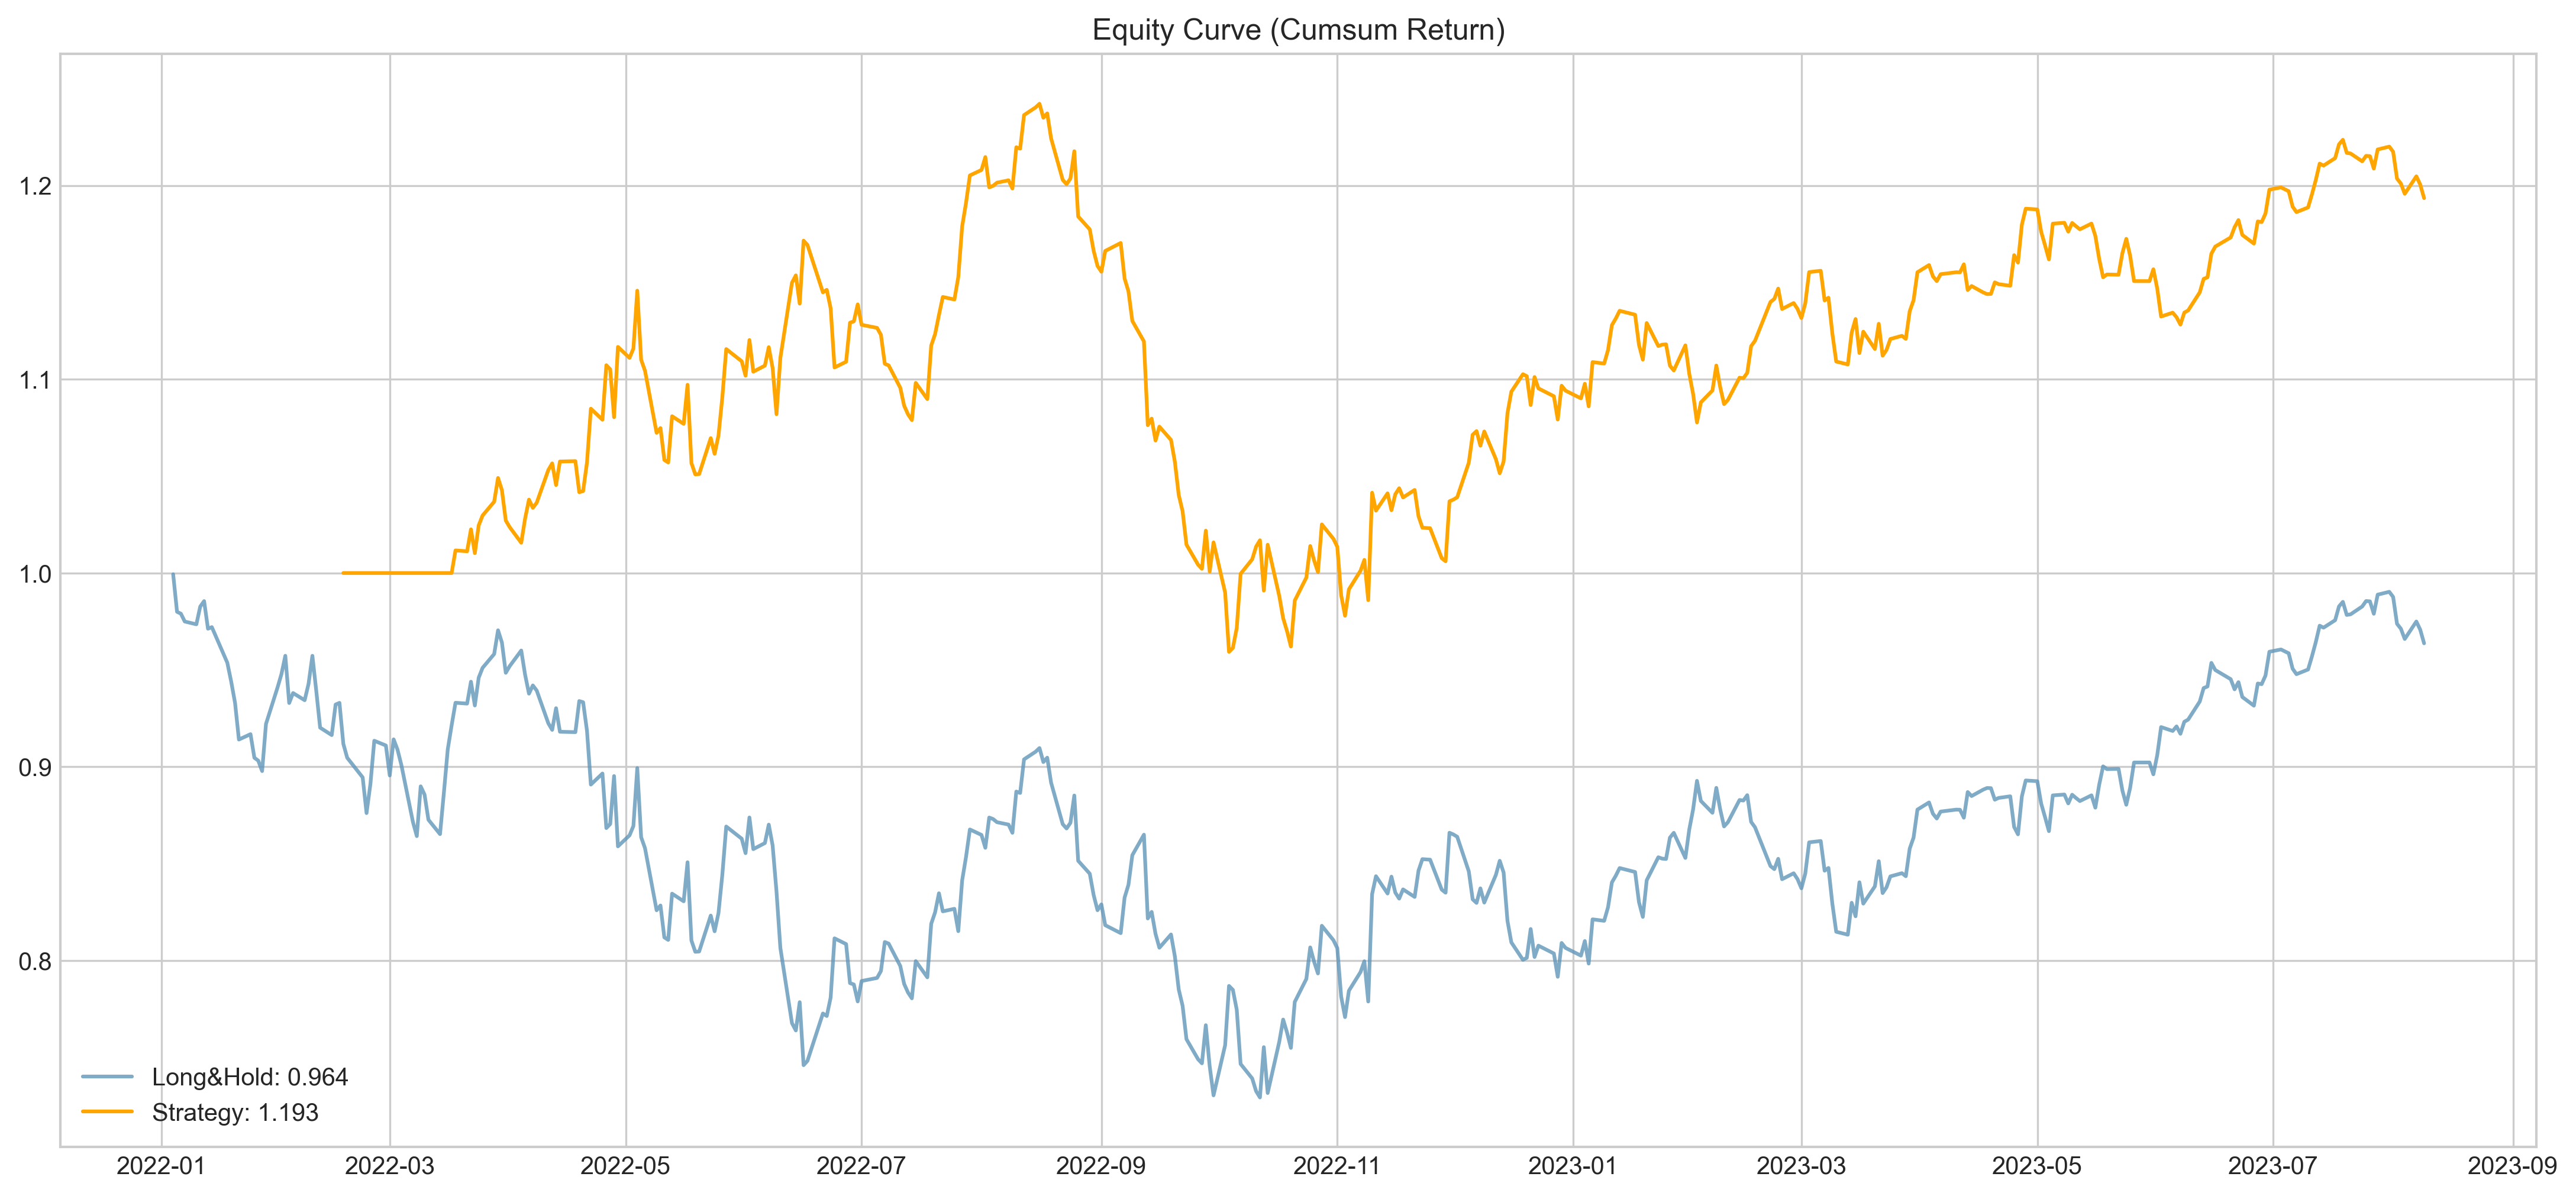

In [16]:
this_obj.plot_equityCurve(plot_long=True, plot_short=False)

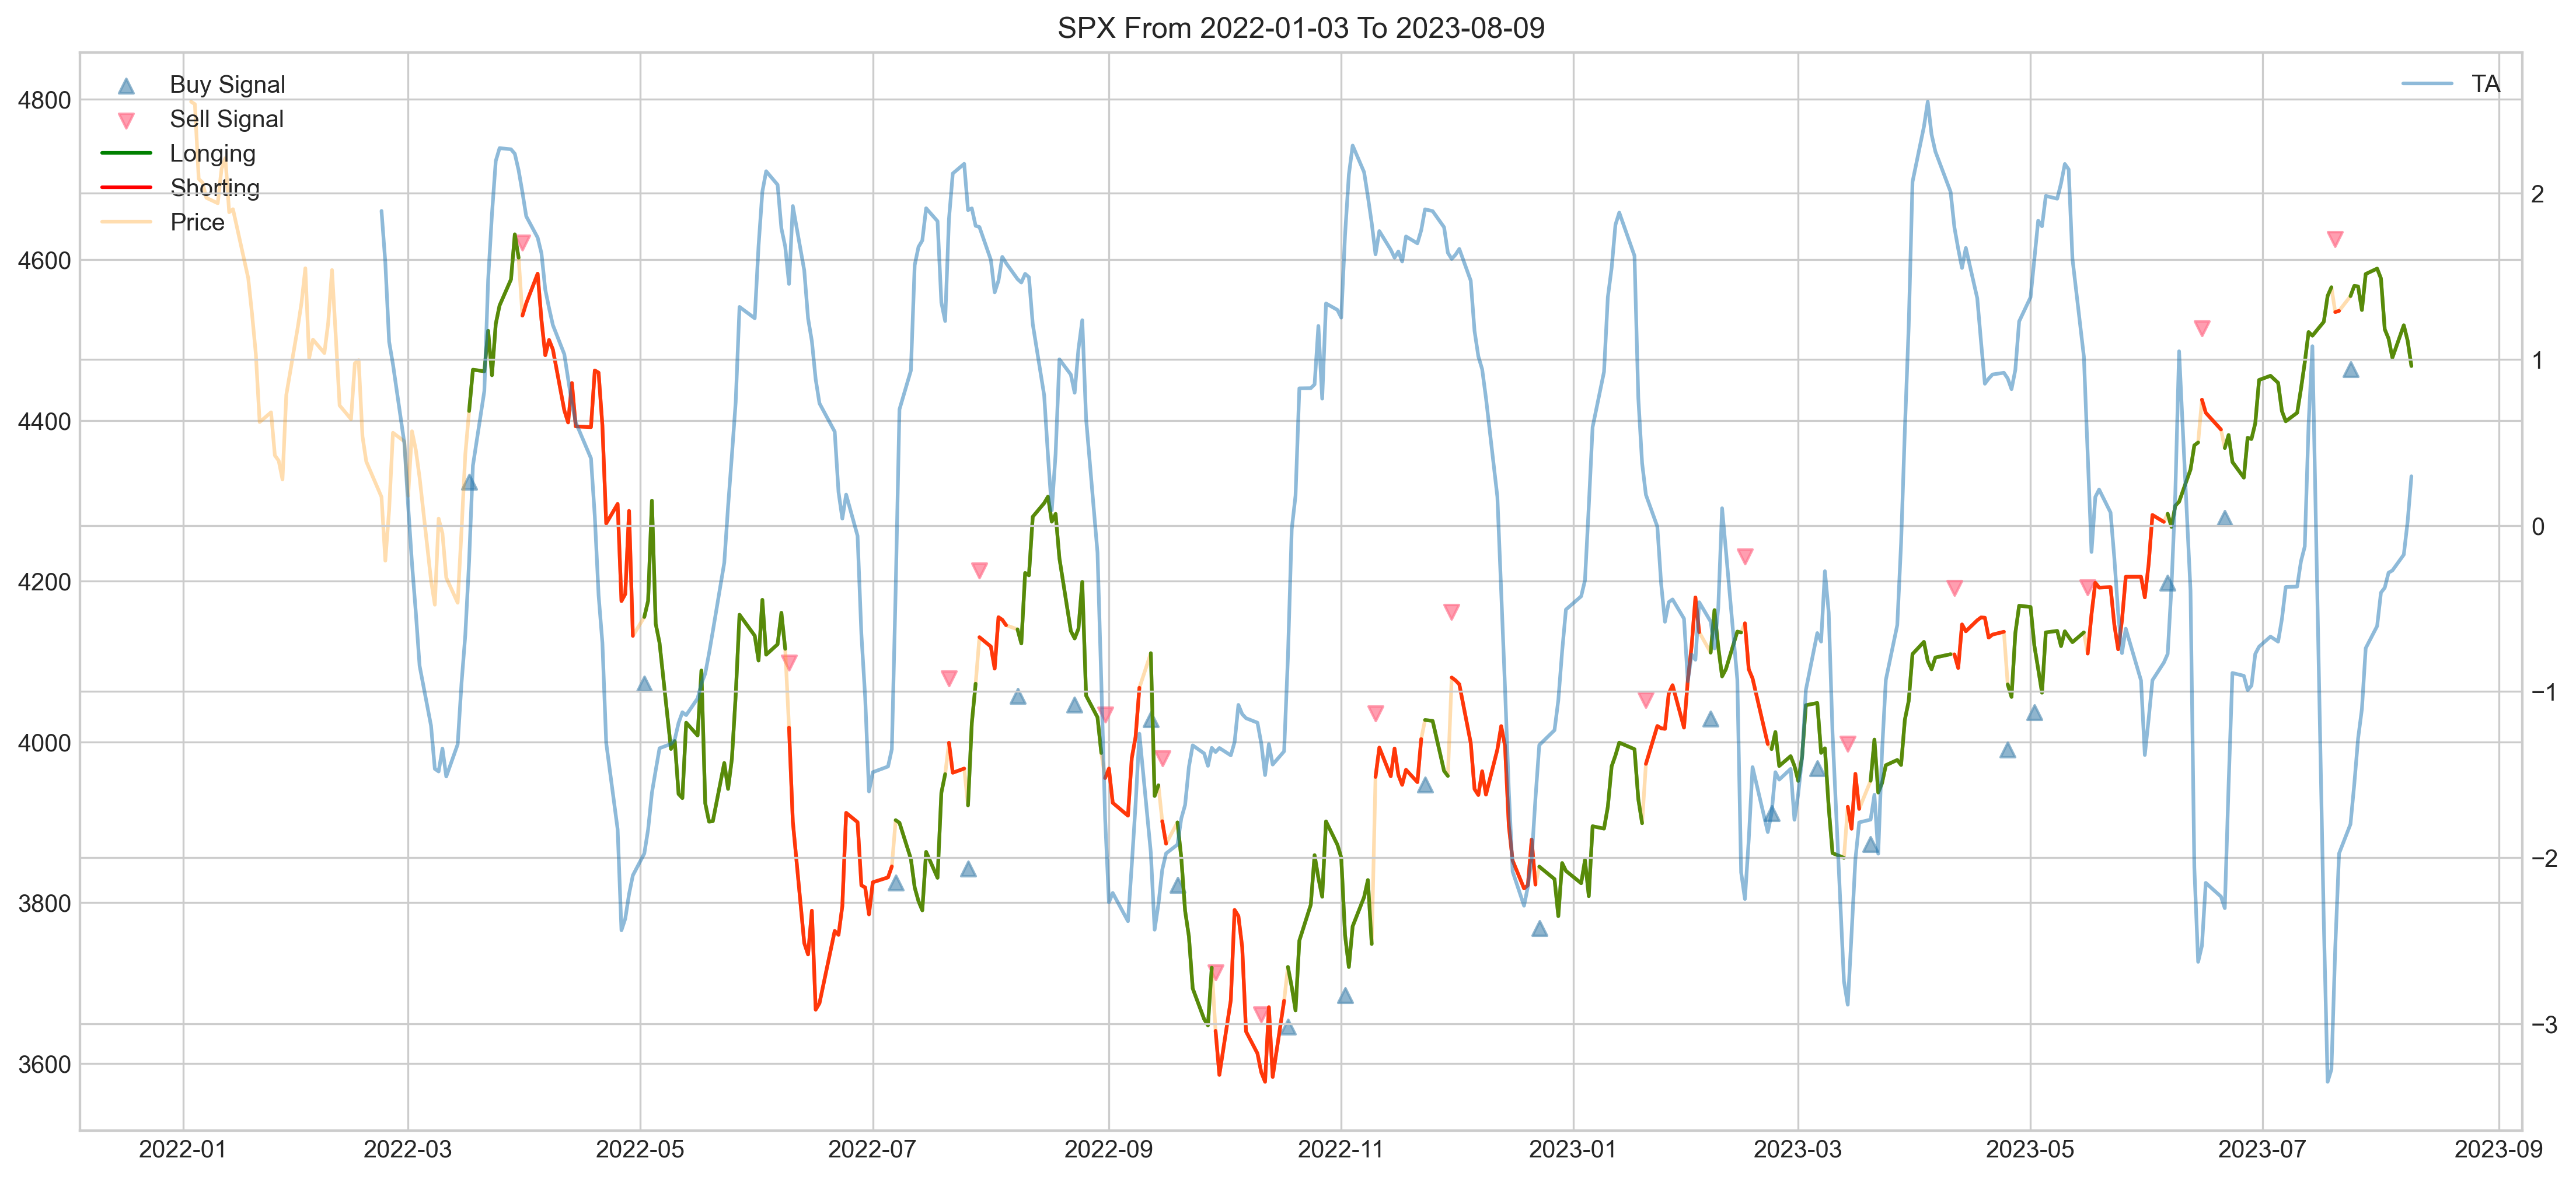

In [17]:
this_obj.plot_signal(plot_extend_position=False)

# Verifcation

In [30]:
window_sma,	window_z, order, holding_n =  minima_bt.iloc[idx, 1:5]
print(window_sma, window_z, order, holding_n) # window_sma,	window_z, order, holding_n = 16, 20, 4, 28

rolling_z = smoothed_rolling_z(spread, window_sma, window_z)
obj_singals = Price_Oscillator_Signal(df_test['SPX'], rolling_z.rename('Rolling Z'))
signals_minima = obj_singals.getSignals_OscillatorExtrema(order)
bt_obj = Vis(df_test['SPX'], signals_minima, ta=rolling_z, holding_n=holding_n, asset_name='SPX')

16 20 4 28


In [31]:
bt_obj = Vis(df_test['SPX'], signals_minima, ta=rolling_z, holding_n=holding_n, asset_name='SPX')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


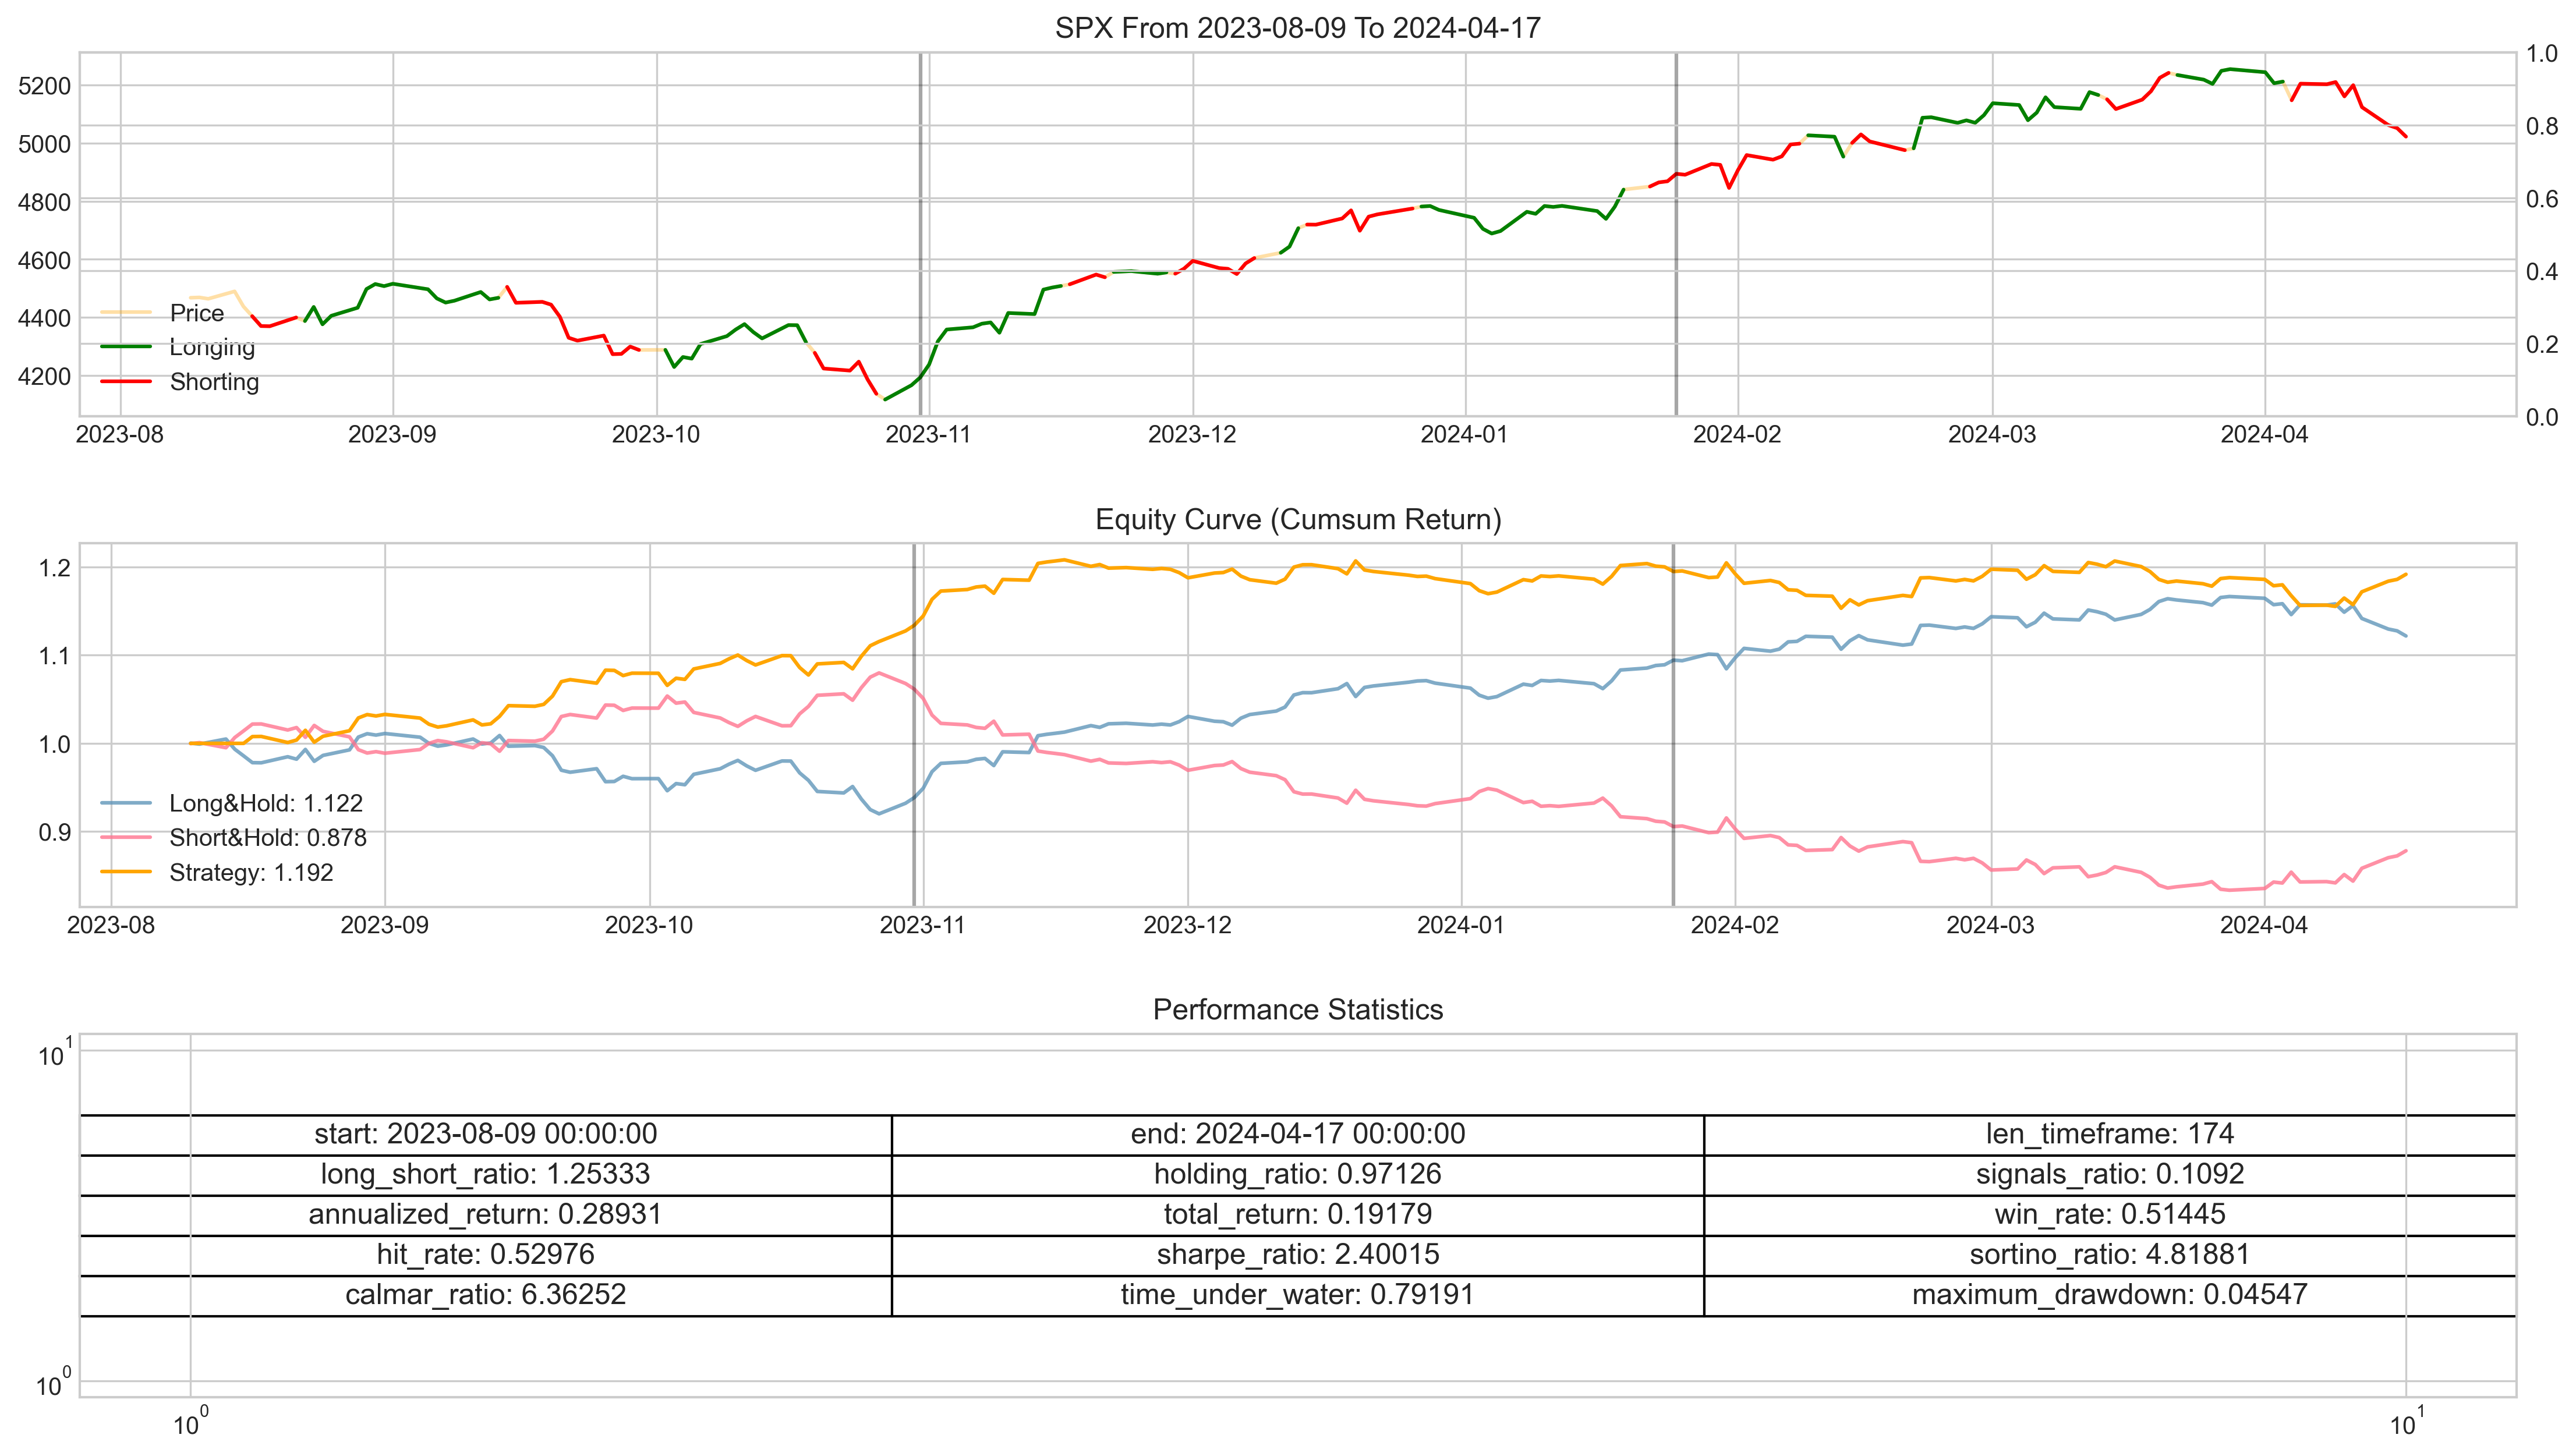

In [32]:
bt_obj.plot_general(config_position={'plot':False})

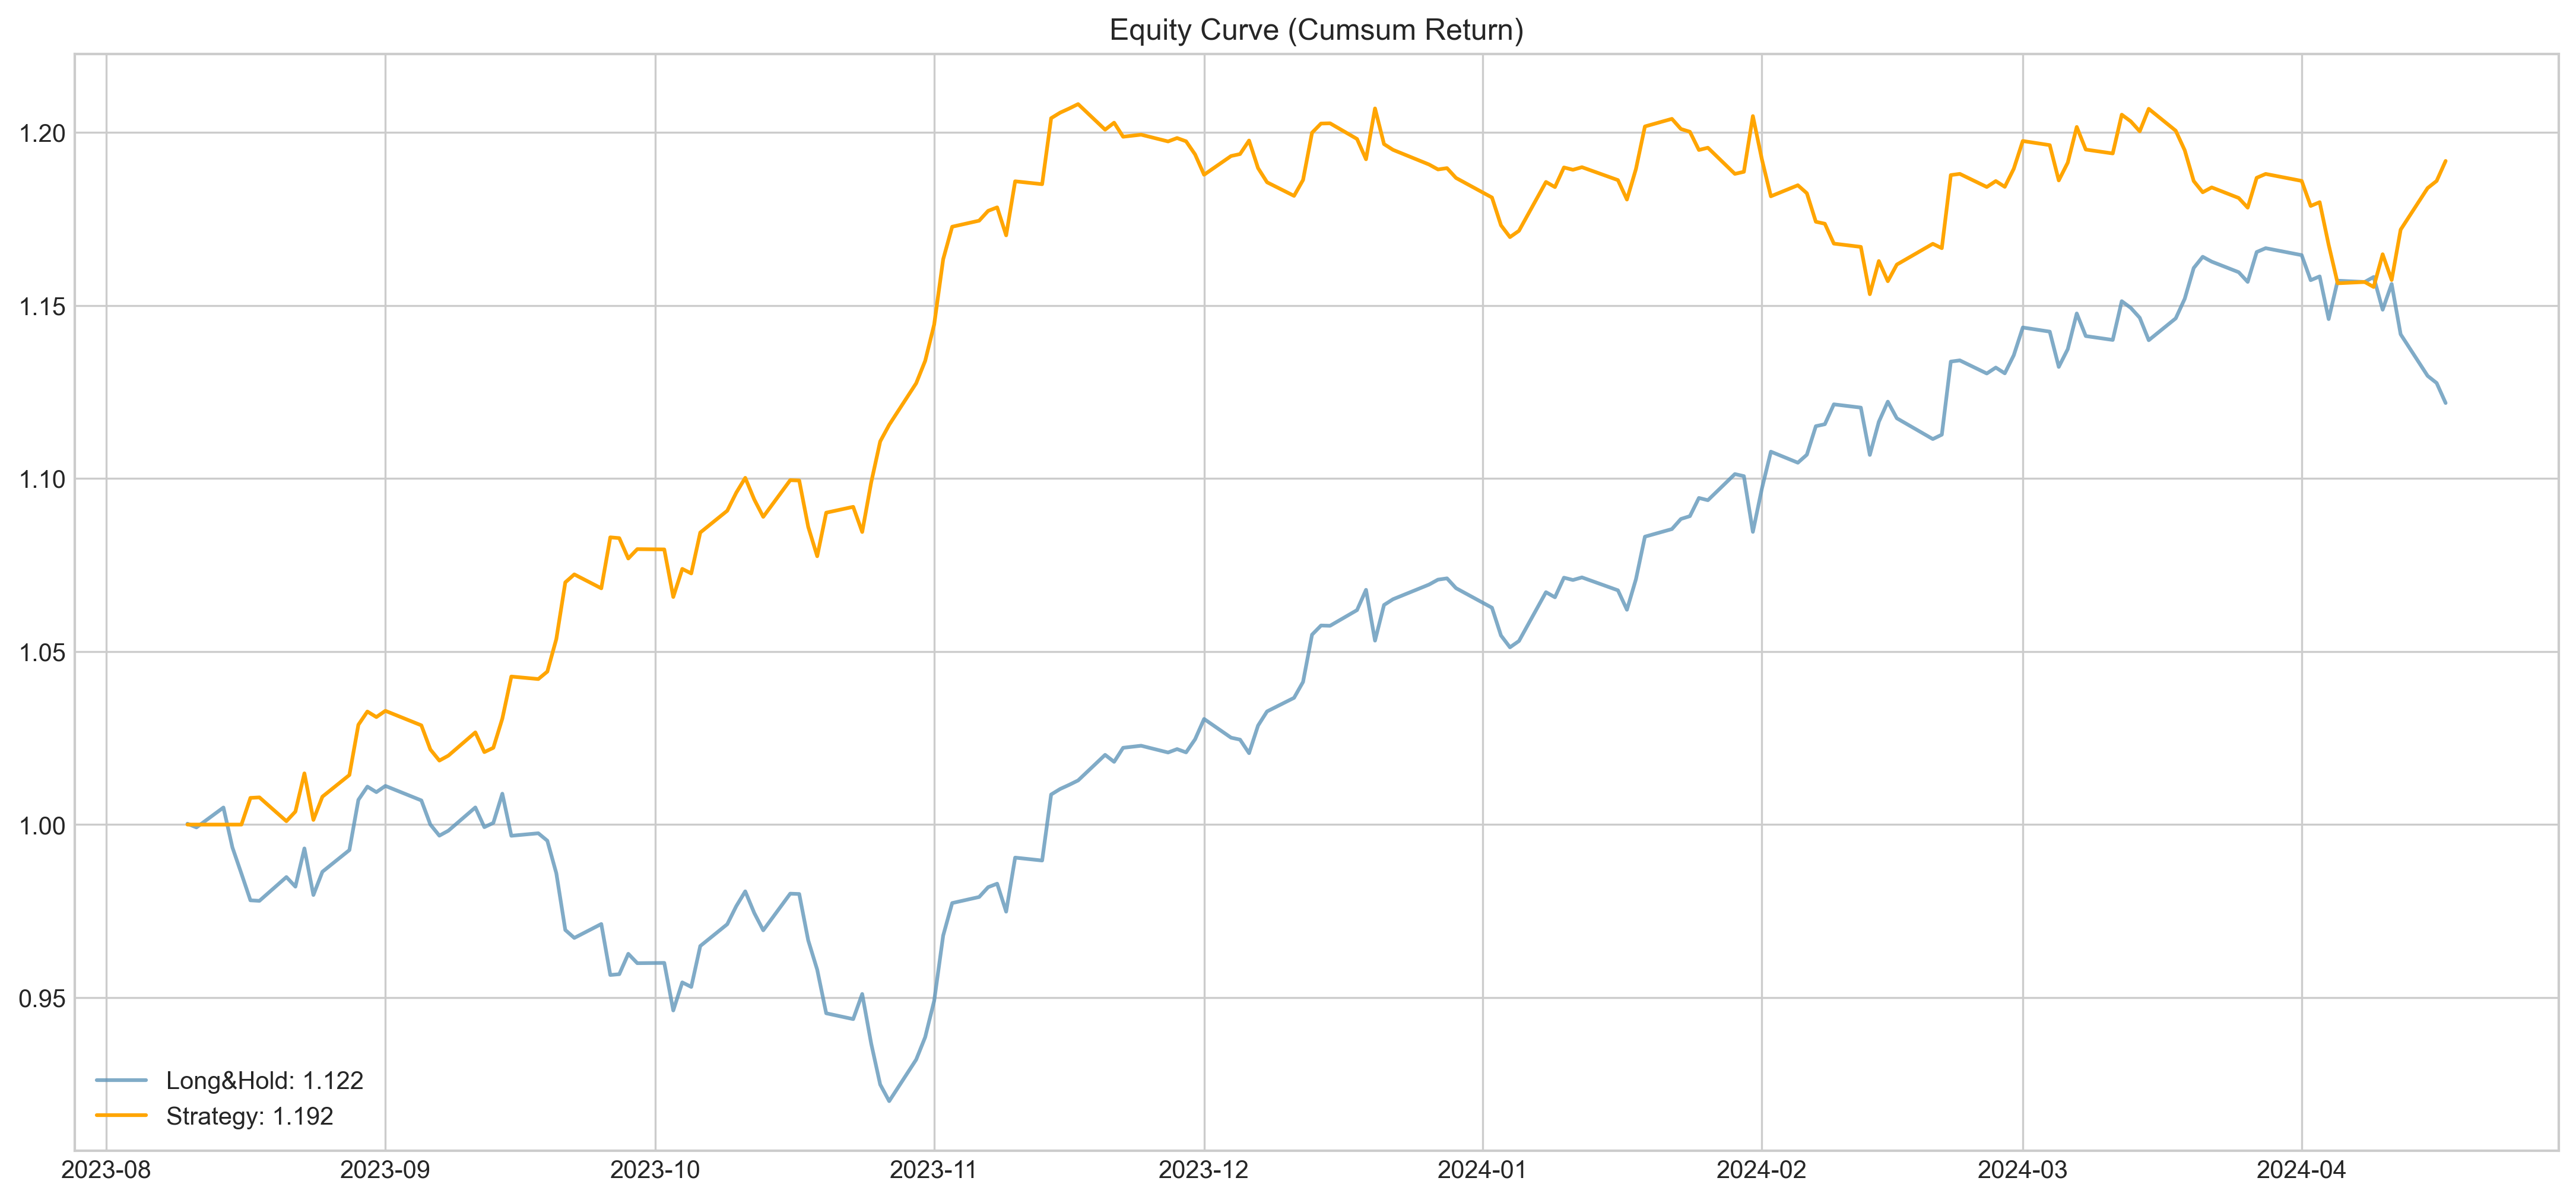

In [33]:
bt_obj.plot_equityCurve(plot_long=True, plot_short=False)

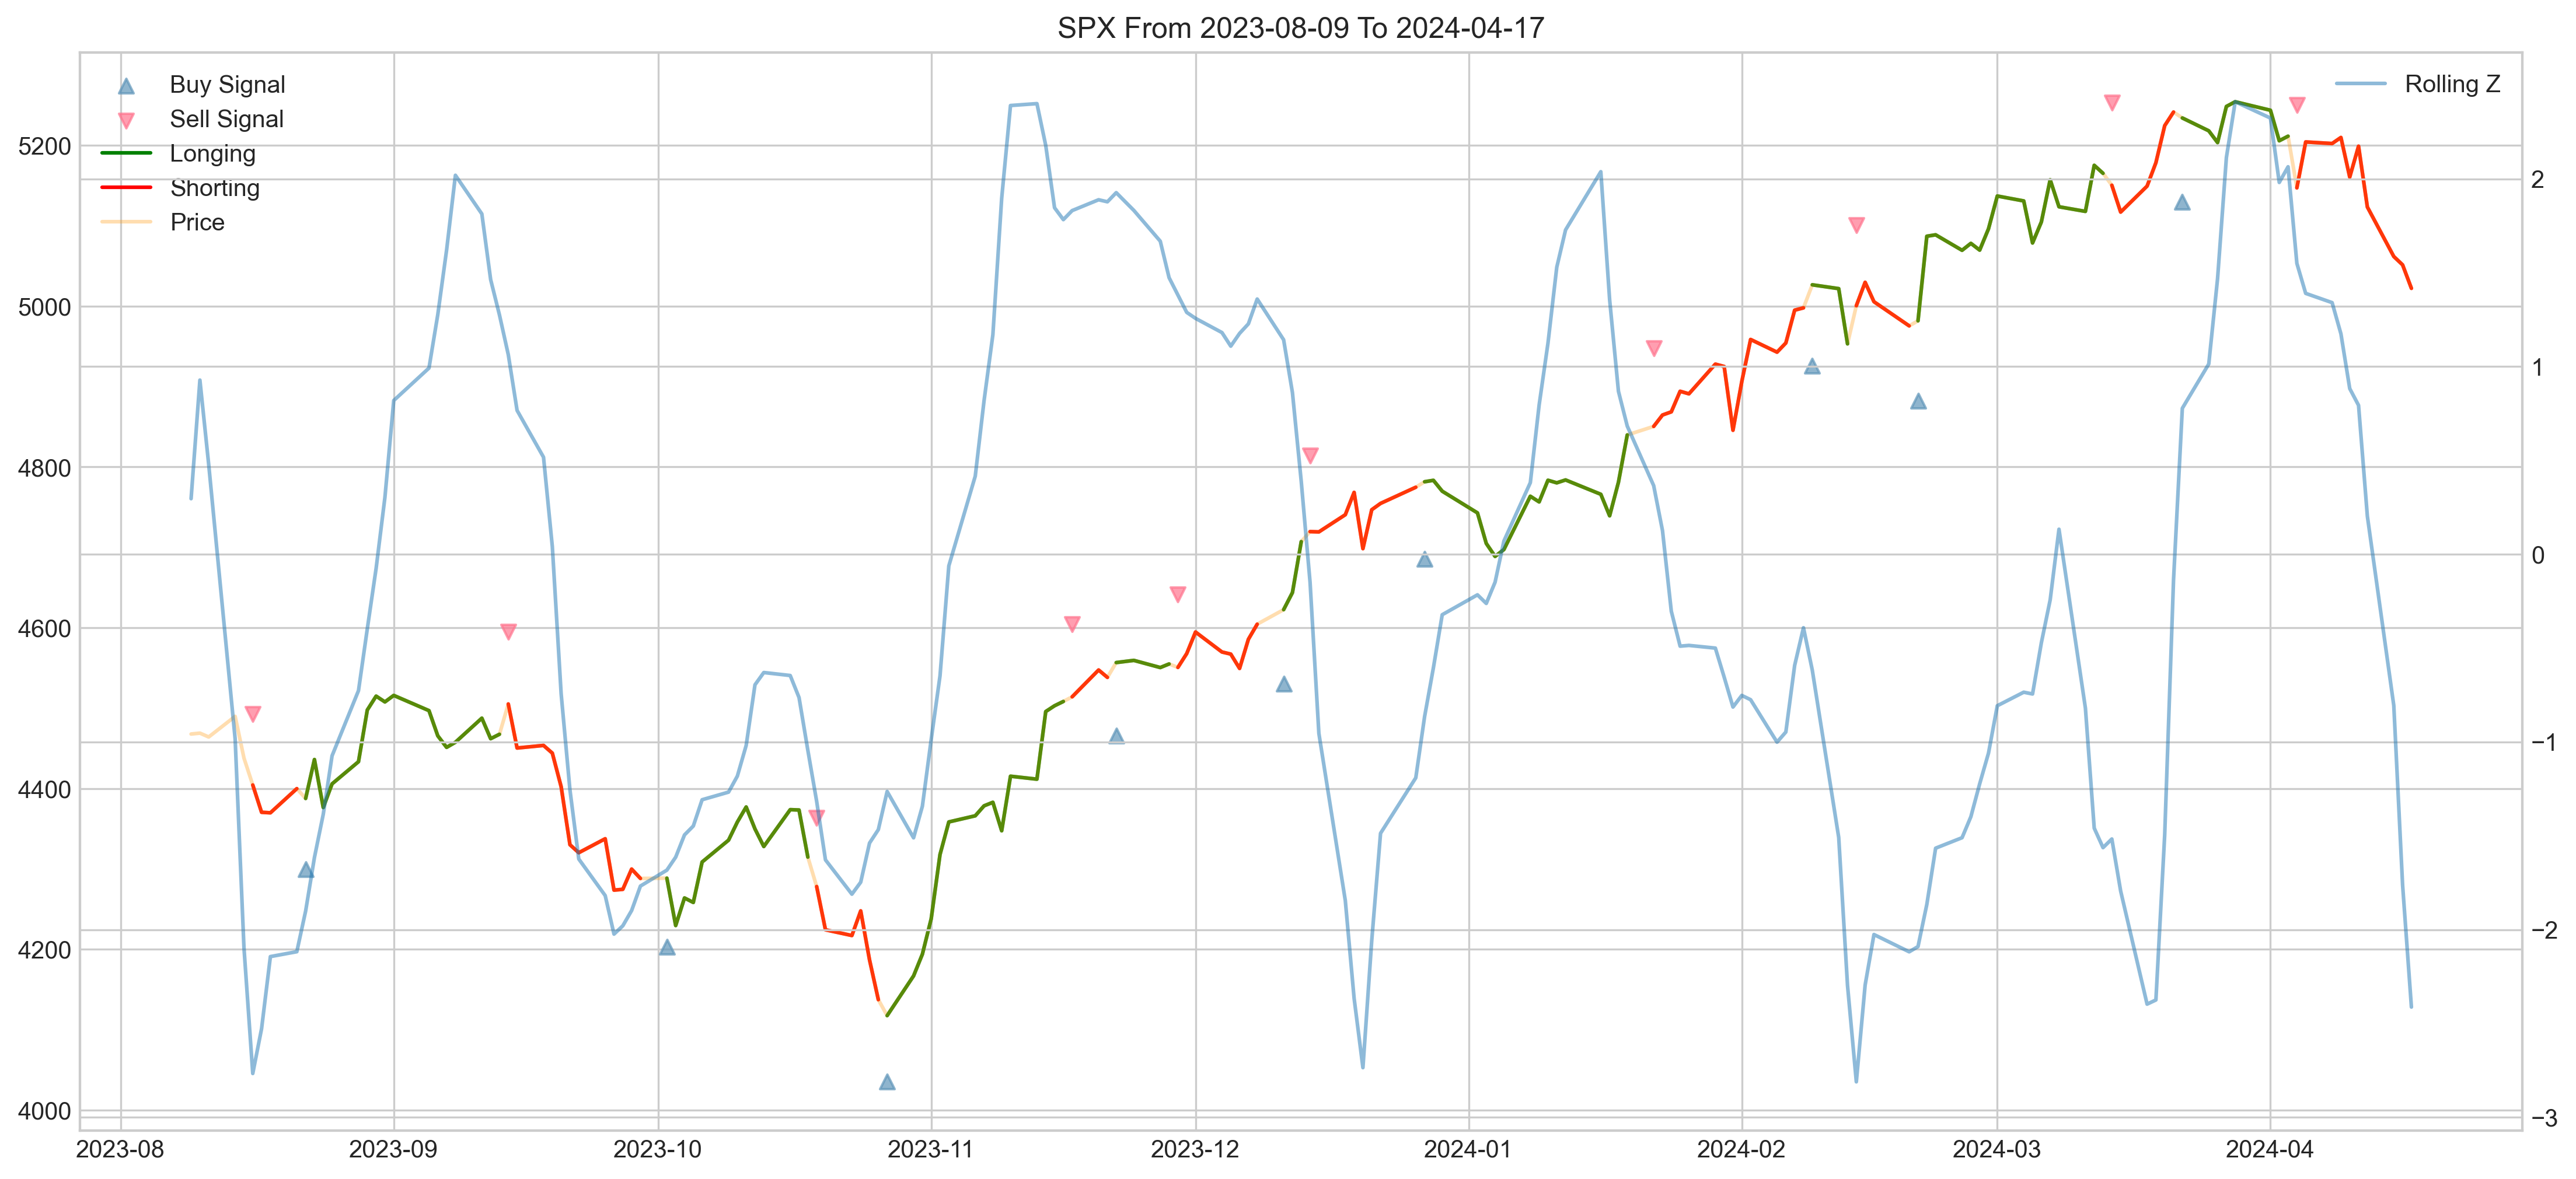

In [34]:
bt_obj.plot_signal(plot_extend_position=False,  name_ta='Rolling Z')

In [35]:
pd.concat([bt_obj.df_bt.tail(20), bt_obj.ta.tail(20)], axis=1)

Open        Close    Return  Position       PnL         0
2024-03-20 00:00:00   NaN  5224.620117  0.008904      -1.0 -0.008904 -1.493432
2024-03-21 00:00:00   NaN  5241.529785  0.003237      -1.0 -0.003237 -0.137427
2024-03-22 00:00:00   NaN  5234.180176 -0.001402       1.0  0.001402  0.777961
2024-03-25 00:00:00   NaN  5218.189941 -0.003055       1.0 -0.003055  1.014005
2024-03-26 00:00:00   NaN  5203.580078 -0.002800       1.0 -0.002800  1.469125
2024-03-27 00:00:00   NaN  5248.490234  0.008631       1.0  0.008631  2.113826
2024-03-28 00:00:00   NaN  5254.350098  0.001116       1.0  0.001116  2.411164
2024-04-01 00:00:00   NaN  5243.770020 -0.002014       1.0 -0.002014  2.324336
2024-04-02 00:00:00   NaN  5205.810059 -0.007239       1.0 -0.007239  1.981209
2024-04-03 00:00:00   NaN  5211.490234  0.001091       1.0  0.001091  2.064735
2024-04-04 00:00:00   NaN  5147.209961 -0.012334      -1.0 -0.012334  1.550055
2024-04-05 00:00:00   NaN  5204.339844  0.011099      -1.0 -0.011099  1.390245
2024-04-08 00:00:00   NaN  5202.390137 -0.000375      -1.0  0.000375  1.340916
2024-04-09 00:00:00   NaN  5209.910156  0.001445      -1.0 -0.001445  1.174731
2024-04-10 00:00:00   NaN  5160.640137 -0.009457      -1.0  0.009457  0.883019
2024-04-11 00:00:00   NaN  5199.060059  0.007445      -1.0 -0.007445  0.793889
2024-04-12 00:00:00   NaN  5123.410156 -0.014551      -1.0  0.014551  0.203286
2024-04-15 00:00:00   NaN  5061.819824 -0.012021      -1.0  0.012021 -0.805677
2024-04-16 00:00:00   NaN  5051.410156 -0.002057      -1.0  0.002057 -1.762186
2024-04-17 00:00:00   NaN  5022.209961 -0.005781      -1.0  0.005781 -2.412125